In [56]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
from models import KuraNet
from train import optimize_connectivity_net
from data import make_data, make_all_data
from utils import yield_zero_column, circular_variance
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# Generate Data

In [13]:
from os.path import expanduser
home = expanduser("~")
data_base_dir = os.path.join(home,'global_synchrony_1')
if not os.path.exists(data_base_dir): os.makedirs(data_base_dir)

num_samples=10000
omega_name='o_uniform2'
h_name='degenerate'
tau_name='negative_binomial'

# Uncomment second and third lines if h and tau are not dirac distributions
make_data(omega_name, data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)
# make_data(h_name, data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)
make_data(tau_name, data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)

# make_all_data(num_samples=args.num_samples,data_dir=args.data_dir)


Generating o_uniform2 train data



Generating o_uniform2 test data



Generating negative_binomial train data



Generating negative_binomial test data


# Set Training Parameters

In [50]:
seed=0
num_units=100
avg_deg=1.0
num_epochs=2 # For tau, use 2
batch_size=100
burn_in_steps=100
gd_steps=50
alpha=.1
solver_method='euler'
rand_inds=False
adjoint=False
loss_type='circular_variance'
optimizer='SGD' # For tau, use SGD
momentum=0.5  # For tau, use .5
max_grad_norm=5.0 # For tau, use 5.0
num_hid_units=128
lr=5e-2 # For tau, use 5e-2
device='cuda'
num_batches = int(num_samples/num_units)

# Load training and testing data.
train_dirs = {}
test_dirs  = {}
train_dss  = {}
test_dss   = {}
train_dls  = {}
test_dls   = {}

for name, dist in zip([omega_name, h_name, tau_name],['omega', 'h', 'tau']):
    if name != 'degenerate':
        train_dirs[dist] = os.path.join(data_base_dir, name, 'train')
        test_dirs[dist] = os.path.join(data_base_dir, name, 'test')
        train_dss[dist] = DatasetFolder(train_dirs[dist], np.load, 'npy')
        test_dss[dist] = DatasetFolder(test_dirs[dist], np.load, 'npy')
        train_dls[dist] = DataLoader(train_dss[dist], batch_size=num_units, shuffle=False, drop_last=True)
        test_dls[dist] = DataLoader(test_dss[dist], batch_size=num_units, shuffle=False, drop_last=True)
    else:
        train_dls[dist] = yield_zero_column(num_batches,num_units)
        test_dls[dist] = yield_zero_column(num_batches,num_units)


# Run Training

In [51]:
np.random.seed(seed)
torch.manual_seed(seed)

loss_train, loss_test, kn, cx = optimize_connectivity_net(num_units, train_dls, test_dls, avg_deg=avg_deg,
                                                      pretrained=False,  num_epochs=num_epochs, batch_size=num_units,
                                                      burn_in_steps=burn_in_steps, gd_steps=gd_steps,alpha=alpha,
                                                      solver_method=solver_method, adjoint=adjoint,
                                                      loss_type=loss_type, optimizer=optimizer,
                                                      lr=lr, momentum=momentum, max_grad_norm=max_grad_norm,
                                                      num_hid_units=num_hid_units, verbose=1, show_every=10,
                                                      num_eval_batches=10, rand_inds=rand_inds, device=device)


Training. Epoch 0.
Training batch: 0. Time/Batch: 1.6208. Loss: 0.8589181303977966. Gradient norm: 0.013478760615436784.
Training batch: 10. Time/Batch: 2.0283. Loss: 0.8666239976882935. Gradient norm: 0.10661520080834644.
Training batch: 20. Time/Batch: 1.3388. Loss: 0.882583737373352. Gradient norm: 0.061813167420313786.
Training batch: 30. Time/Batch: 1.2555. Loss: 0.8042191863059998. Gradient norm: 0.22461499552959746.
Training batch: 40. Time/Batch: 2.0936. Loss: 0.6255814433097839. Gradient norm: 0.3699200864538572.
Training batch: 50. Time/Batch: 1.7937. Loss: 0.5363006591796875. Gradient norm: 0.5474901277446109.
Training batch: 60. Time/Batch: 1.6482. Loss: 0.5576158165931702. Gradient norm: 0.27879248910851123.
Training batch: 70. Time/Batch: 1.6543. Loss: 0.4535251557826996. Gradient norm: 0.4379122901220796.
Training batch: 80. Time/Batch: 1.2711. Loss: 0.5118836760520935. Gradient norm: 0.3086722491847349.
Training batch: 90. Time/Batch: 1.7474. Loss: 0.48496875166893005. 

# Visualization

Optimized loss: 0.4609
Control loss: 0.9209


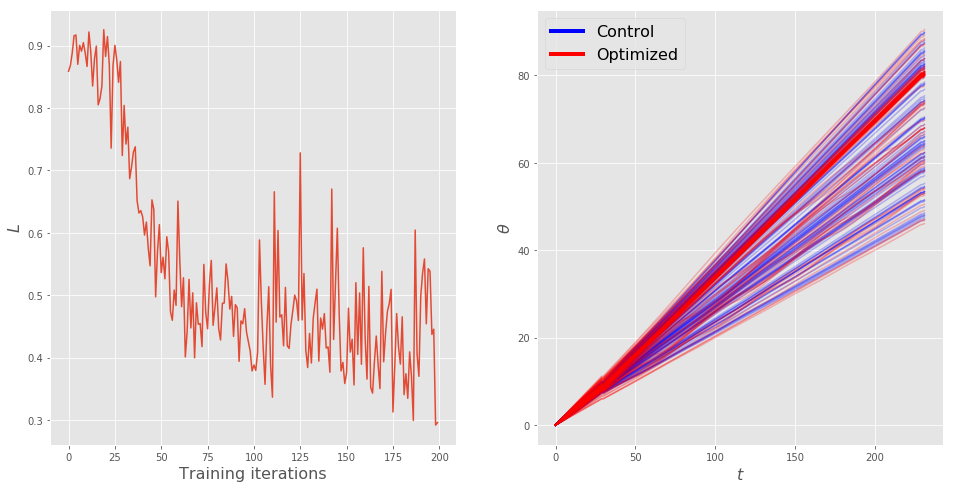

In [61]:
visualization_time=200
kn_control = KuraNet(3, avg_deg=avg_deg, num_hid_units=num_hid_units,
                      rand_inds=rand_inds,
                      adjoint=adjoint, solver_method=solver_method,
                      alpha=alpha, gd_steps=1,
                      burn_in_steps=visualization_time).to(device)
kn_control.set_batch_size(batch_size)

kn.set_grids(alpha, visualization_time, 1)

# Load one testing batch
for j, ((omega, _),(h, _), (tau, _)) in enumerate(zip(test_dls['omega'], test_dls['h'], test_dls['tau'])):
    tau = torch.where(tau > 40.0, 40.0 * torch.ones_like(tau),tau)
    x = torch.cat([omega,h, tau],dim=-1).to(device)
    break
    
flow = kn.run(x)
flow_control = kn_control.run(x)
print('Optimized loss: %.04f' % circular_variance(flow[burn_in_steps:]))
print('Control loss: %.04f' % circular_variance(flow_control[burn_in_steps:]))

flow = flow.data.cpu().numpy() 
flow_control=flow_control.data.cpu().numpy()

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color='b', lw=4),
         Line2D([0], [0], color='r', lw=4)]


fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(loss_train)
axes[0].set_xlabel('Training iterations', fontsize=16)
axes[0].set_ylabel(r'$L$', fontsize=16)
axes[1].plot(flow_control, color='b', alpha=.25)
axes[1].plot(flow, color='r', alpha=.25)
axes[1].legend(lines, ['Control', 'Optimized'], fontsize=16)
axes[1].set_xlabel(r'$t$', fontsize=16)
axes[1].set_ylabel(r'$\theta$', fontsize=16)
plt.show()
plt.close()

# Animation

In [ ]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

fig, axes = plt.subplots(2,1, figsize=(16,8))

flow_x        = np.cos(flow)
fow_x_control = np.cos(flow_control)
flow_y        = np.sin(flow)
fow_x_control = np.sin(flow_control)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):

    line.set_data(x, y)
    return (line,)

for ax, fl in zip(axes, [[flow_x, flow_y],[flow_x_control, flow_y_control]]):
    ax.set_xlim(( -1.25, 1.25))
    ax.set_ylim((-1.25, 1.25))

    circle = plt.Circle((0, 0), 0.2, color='gray', fill=False)
    ax.add_patch(circle)
    line, = ax.scatter(fl[0], fl[1])